# Challenge

Unit 3:3:4

Pick a dataset of your choice with a binary outcome and the potential for at least 15 features. If you're drawing a blank, the crime rates in 2013 dataset has a lot of variables that could be made into a modelable binary outcome.

Engineer your features, then create three models. Each model will be run on a training set and a test-set (or multiple test-sets, if you take a folds approach). The models should be:

- Vanilla logistic regression
- Ridge logistic regression
- Lasso logistic regression

In your report, evaluate all three models and decide on your best. Be clear about the decisions you made that led to these models (feature selection, regularization parameter selection, model evaluation criteria) and why you think that particular model is the best of the three. Also reflect on the strengths and limitations of regression as a modeling approach. Were there things you couldn't do but you wish you could have done?

## Data

From [Kaggle](https://www.kaggle.com/secareanualin/football-events/data)

This dataset is a result of a very tiresome effort of webscraping and integrating different data sources. The central element is the text commentary. All the events were derived by reverse engineering the text commentary, using regex. Using this, I was able to derive 11 types of events, as well as the main player and secondary player involved in those events and many other statistics. In case I've missed extracting some useful information, you are gladly invited to do so and share your findings. The dataset provides a granular view of 9,074 games, totaling 941,009 events from the biggest 5 European football (soccer) leagues: England, Spain, Germany, Italy, France from 2011/2012 season to 2016/2017 season as of 25.01.2017. There are games that have been played during these seasons for which I could not collect detailed data. Overall, over 90% of the played games during these seasons have event data.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection 
import statsmodels.api as sm
%matplotlib inline
sns.set_style('white')

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
matches = pd.read_csv('C:\\Users\\User\\Documents\\Python_scripts\\Thinkful\\football-events\\events.csv')
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941009 entries, 0 to 941008
Data columns (total 22 columns):
id_odsp          941009 non-null object
id_event         941009 non-null object
sort_order       941009 non-null int64
time             941009 non-null int64
text             941009 non-null object
event_type       941009 non-null int64
event_type2      214293 non-null float64
side             941009 non-null int64
event_team       941009 non-null object
opponent         941009 non-null object
player           880009 non-null object
player2          291310 non-null object
player_in        51715 non-null object
player_out       51738 non-null object
shot_place       227459 non-null float64
shot_outcome     228498 non-null float64
is_goal          941009 non-null int64
location         467067 non-null float64
bodypart         229185 non-null float64
assist_method    941009 non-null int64
situation        229137 non-null float64
fast_break       941009 non-null int64
dtypes: floa

**event_type**
0	Announcement
1	Attempt
2	Corner
3	Foul
4	Yellow card
5	Second yellow card
6	Red card
7	Substitution
8	Free kick won
9	Offside
10	Hand ball
11	Penalty conceded

**event_type2**
12	Key Pass
13	Failed through ball
14	Sending off
15	Own goal

**shot_place**
1	Bit too high
2	Blocked
3	Bottom left corner
4	Bottom right corner
5	Centre of the goal
6	High and wide
7	Hits the bar
8	Misses to the left
9	Misses to the right
10	Too high
11	Top centre of the goal
12	Top left corner
13	Top right corner

**shot_outcome**
1	On target
2	Off target
3	Blocked
4	Hit the bar


**location**
1	Attacking half
2	Defensive half
3	Centre of the box
4	Left wing
5	Right wing
6	Difficult angle and long range
7	Difficult angle on the left
8	Difficult angle on the right
9	Left side of the box
10	Left side of the six yard box
11	Right side of the box
12	Right side of the six yard box
13	Very close range
14	Penalty spot
15	Outside the box
16	Long range
17	More than 35 yards
18	More than 40 yards
19	Not recorded


**bodypart**
1	right foot
2	left foot
3	head

**situation**
1	Open play
2	Set piece
3	Corner
4	Free kick


In [3]:
matches.event_type.value_counts() 

8     237932
3     232925
1     229135
2      91204
7      51738
9      43476
4      39911
10     10730
11      2706
6       1152
5        100
Name: event_type, dtype: int64

For this exercise I'm only interested in 1 Attempt (at goal)

In [35]:
# Keeping only attempts at goal, and relevant columns
attempt = matches.loc[matches['event_type']==1,'shot_place':'fast_break']
attempt.drop('shot_outcome', axis=1, inplace=True)
attempt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229135 entries, 0 to 941006
Data columns (total 7 columns):
shot_place       227452 non-null float64
is_goal          229135 non-null int64
location         229135 non-null float64
bodypart         229135 non-null float64
assist_method    229135 non-null int64
situation        229135 non-null float64
fast_break       229135 non-null int64
dtypes: float64(4), int64(3)
memory usage: 14.0 MB


In [62]:
attempt.is_goal.value_counts(normalize=True)

0    0.893334
1    0.106666
Name: is_goal, dtype: float64

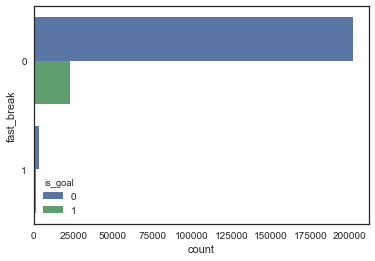

In [25]:
sns.countplot(y='fast_break', hue='is_goal', data=attempt)

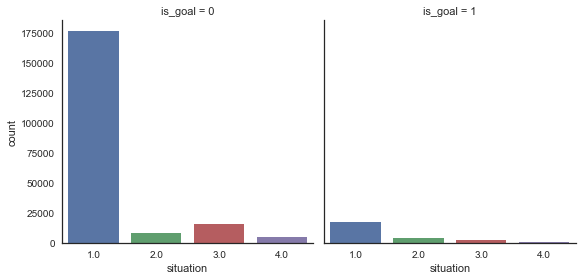

In [23]:
sns.factorplot(x='situation', col='is_goal', data=attempt, kind='count')

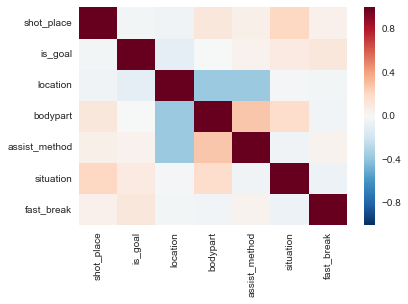

In [36]:
corrs = attempt.corr()

sns.heatmap(corrs)
plt.show()

In [66]:
#Convert features to category dtype to convert to dummies (fast_break already binary)
attempt['shot_place'] = attempt['shot_place'].astype('category')
attempt['location'] = attempt['location'].astype('category')
attempt['bodypart'] = attempt['bodypart'].astype('category')
attempt['assist_method'] = attempt['assist_method'].astype('category')
attempt['situation'] = attempt['situation'].astype('category')

#Convert to dummies and drop is_goal
X = pd.get_dummies(attempt)
X.drop('is_goal', axis=1, inplace=True)
y = attempt['is_goal']

# Remove base categories for dummy variables
X_dummy = X.loc[:, ~((X.columns).isin(['shot_place_1.0', 'location_18.0', 'bodypart_3.0',
                                 'assist_method_4', 'situation_1.0']))]

# Splitting data
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_dummy, y)


## OLS

In [67]:
# Use Statsmodels to get unregularized logit model

# Reformat data to  beStatsmodel friendly
train = X_train.copy()

# Manually add intercept... grrrr
train['intercept'] = 1

# List for patsy formulation
#all_columns = " + ".join(train.columns)
#my_formula = "y ~ " + all_columns
#print(my_formula)

# Add back y to create single dataset
#train['y'] = y_train

lgt = sm.Logit(y_train, train)
results  = lgt.fit()
print(results.summary())

         Current function value: 0.148773
         Iterations: 35


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                is_goal   No. Observations:               171851
Model:                          Logit   Df Residuals:                   171814
Method:                           MLE   Df Model:                           36
Date:                Wed, 28 Feb 2018   Pseudo R-squ.:                  0.5604
Time:                        21:30:41   Log-Likelihood:                -25567.
converged:                      False   LL-Null:                       -58153.
                                        LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
fast_break          3.3592      0.090     37.471      0.000       3.184       3.535
shot_place_2.0    -13.1362     17.482     -0.751      0.452     -47.401      21.129
shot_place_3.0      2.3712      

In [71]:
# Adding intercept again
X_test_intercept = X_test.copy()
X_test_intercept['intercept'] = 1

y_hat = results.predict(X_test_intercept)
#accuracy = lgt.score(y_test, X_test_intercept)

In [80]:
# Threshold of .5
threshold = np.where(y_hat>0.5,1,0)
cross = pd.crosstab(threshold, y_test)
print(cross)
acc = (cross[0][0]+cross[1][1])/len(y_hat)
print('Accuracy is: ', acc) 

is_goal      0     1
row_0               
0        49694  2460
1         1391  3739
Accuracy is:  0.932773549333


The model struggles with convergence. Luckily Ridge and Lasso were partly designed to fix this!

The model has high accuracy, but is not a particularly strong predictor given that 89% of the shots were not goals.

But first a more sensible model with some of the dummies drop (e.g. you can't score a goal if your shot_place was 1, 2, 6, 7, 8, 9, 10)

In [43]:
# Remove extra variable for intercept (shot_place5.0 centre of goal)
train_small = train.loc[:, ~((train.columns).isin(['shot_place_1.0', 'shot_place_2.0', 'shot_place_6.0',
                                                   'shot_place_7.0', 'shot_place_8.0', 'shot_place_9.0',
                                                   'shot_place_10.0']))]

lgt = sm.Logit(y_train, train_small)
results  = lgt.fit()
print(results.summary())

         Current function value: 0.161227
         Iterations: 35


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                is_goal   No. Observations:               171851
Model:                          Logit   Df Residuals:                   171820
Method:                           MLE   Df Model:                           30
Date:                Wed, 28 Feb 2018   Pseudo R-squ.:                  0.5271
Time:                        17:20:23   Log-Likelihood:                -27707.
converged:                      False   LL-Null:                       -58592.
                                        LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
fast_break          3.1800      0.072     43.960      0.000       3.038       3.322
shot_place_3.0      5.3121      0.051    104.959      0.000       5.213       5.411
shot_place_4.0      5.2017      

## Ridge

In [46]:
# SKLearn already has penalty
ols = linear_model.LogisticRegression()
ols.fit(X_train, y_train)
r2_train = ols.score(X_train, y_train)
params = ols.get_params()
print(params)
print(r2_train)

#Back to sklearn
r2_test = ols.score(X_test, y_test)
print(r2_test)


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
0.933384152551
0.933838419105


In [87]:
# Preprocessing
prepX = pd.DataFrame(preprocessing.scale(X_dummy), columns=X_dummy.columns)

# Splitting data
prepX_train, prepX_test, prepy_train, prepy_test = model_selection.train_test_split(X_dummy, y)

# SKLearn already has penalty
ols = linear_model.LogisticRegression()
ols.fit(prepX_train, prepy_train)
r2_train = ols.score(prepX_train, prepy_train)
params = ols.get_params()
print(params)
print(r2_train)

#Back to sklearn
r2_test = ols.score(prepX_test, prepy_test)
print(r2_test)

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
0.933721654224
0.933262342015


## Lasso

In [61]:
# SKLearn already has penalty
# Run with no intercept (all dummies included)
ols = linear_model.LogisticRegression(penalty='l1', fit_intercept=False)
ols.fit(X_train, y_train)
r2_train = ols.score(X_train, y_train)
params = ols.get_params()
print(params)
print(r2_train)

#Back to sklearn
r2_test = ols.score(X_test, y_test)
print(r2_test)

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': False, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
0.932959365962
0.933279798897


In [60]:
features = list(X_train.columns)
coefs = list(ols.coef_.ravel())
table = zip(features, coefs)
for tab in table:
    print(list(tab))

['fast_break', 3.2439900643530564]
['shot_place_2.0', -5.6384406882584113]
['shot_place_3.0', 2.4103182518504433]
['shot_place_4.0', 2.265995301665666]
['shot_place_5.0', 0.99821756249148719]
['shot_place_6.0', -5.5586950542596227]
['shot_place_7.0', -4.9897927534496427]
['shot_place_8.0', -6.2903032925827214]
['shot_place_9.0', -6.2722307356146842]
['shot_place_10.0', -5.9347997095034133]
['shot_place_11.0', -3.8120666096242042]
['shot_place_12.0', 2.0699107434966635]
['shot_place_13.0', 2.1822340559550759]
['location_3.0', 0.90340729112884333]
['location_6.0', -1.6288167631364276]
['location_7.0', -0.46484028875614936]
['location_8.0', -0.73349931490082432]
['location_9.0', -0.58684183405021195]
['location_10.0', 0.96954852184321716]
['location_11.0', -0.46255811269642905]
['location_12.0', 1.1218513572787718]
['location_13.0', 2.62193924059682]
['location_14.0', 0.26458266234061933]
['location_15.0', -1.0682362591950028]
['location_16.0', -1.7147297641440302]
['location_17.0', -1.78

In [82]:
# Ridge in statsmodel to see output

lgt = sm.Logit(y_train, train)
results  = lgt.fit_regularized(method='l1')
print(results.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.14877268772728358
            Iterations: 295
            Function evaluations: 295
            Gradient evaluations: 295
                           Logit Regression Results                           
Dep. Variable:                is_goal   No. Observations:               171851
Model:                          Logit   Df Residuals:                   171814
Method:                           MLE   Df Model:                           36
Date:                Wed, 28 Feb 2018   Pseudo R-squ.:                  0.5604
Time:                        21:46:57   Log-Likelihood:                -25567.
converged:                       True   LL-Null:                       -58153.
                                        LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

In [83]:
y_hat = results.predict(X_test_intercept)
#accuracy = lgt.score(y_test, X_test_intercept)
# Threshold of .5
threshold = np.where(y_hat>0.5,1,0)
cross = pd.crosstab(threshold, y_test)
print(cross)
acc = (cross[0][0]+cross[1][1])/len(y_hat)
print('Accuracy is: ', acc) 

is_goal      0     1
row_0               
0        49694  2460
1         1391  3739
Accuracy is:  0.932773549333


## Conclusion

The logit model did not converge and therefore would not be a stable model to use. However, the ridge and lasso models were much more efficient in finding a solution. With the ridge there is some loss in interpretation (sklearn's output isn't particularly useful). While the Lasso model took less time, it had the exact same predictive power as the logit. This may be as the features do no exhibit high collinearity (which the Lasso model can correct).